In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPool2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing \
import RandomFlip,RandomRotation,Rescaling,RandomContrast

In [16]:
train_df = image_dataset_from_directory('/content/drive/MyDrive/Face Mask Dataset/Train',
                                       labels='inferred',
                                       label_mode='binary',
                                       interpolation='nearest',
                                       image_size=[128,128],
                                       batch_size=32,
                                       shuffle=True,
                                       )

Found 10000 files belonging to 2 classes.


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
valid_df = image_dataset_from_directory('/content/drive/MyDrive/Face Mask Dataset/Validation',
                                       labels='inferred',
                                       label_mode='binary',
                                       interpolation='nearest',
                                       image_size=[128,128],
                                       batch_size=32,
                                       shuffle=True,
                                       )

Found 800 files belonging to 2 classes.


In [19]:
test_df = image_dataset_from_directory('/content/drive/MyDrive/Face Mask Dataset/Test',
                                       labels='inferred',
                                       label_mode='binary',
                                       interpolation='nearest',
                                       image_size=[128,128],
                                       batch_size=32,
                                       shuffle=True,
                                       )

Found 992 files belonging to 2 classes.


In [20]:
class_name = train_df.class_names

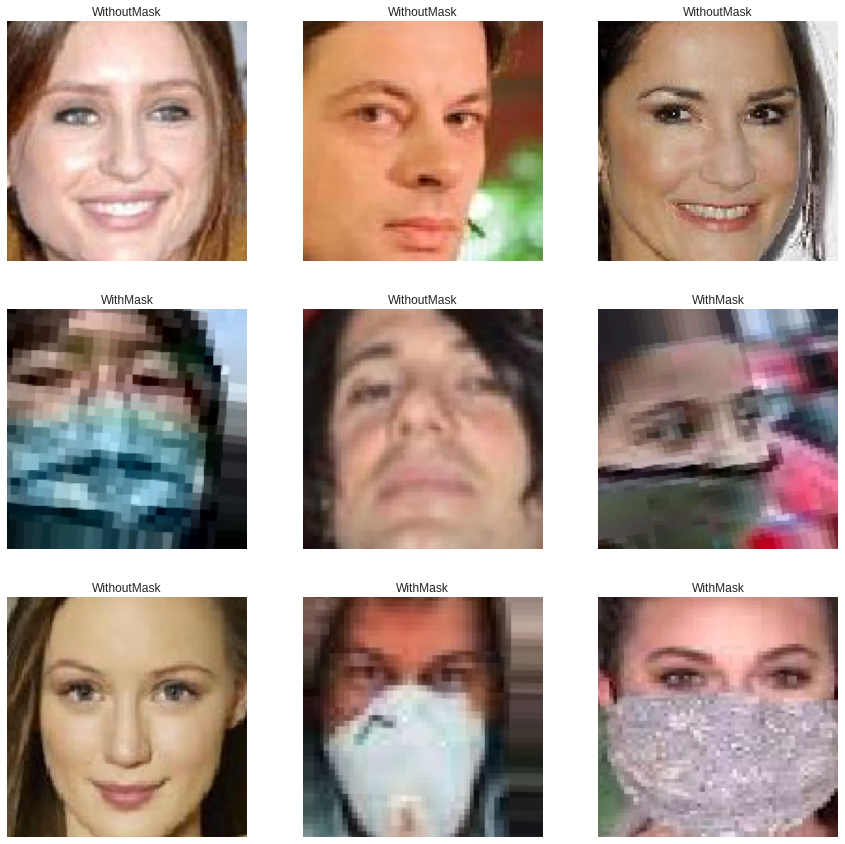

In [21]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

plt.figure(figsize=(15,15))
for img, label in train_df.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_name[int(label[i])])
        plt.axis('off')

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_df = train_df.cache().prefetch(buffer_size=AUTOTUNE)
valid_df = valid_df.cache().prefetch(buffer_size=AUTOTUNE)
test_df = test_df.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
model = Sequential([
    Rescaling(1.0/255,input_shape=(128,128,3)),
    RandomFlip(),
    RandomRotation(0.4),
    RandomContrast(0.3),
    
    # First Layer
    layers.Conv2D(filters=64, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Second Layer
    layers.Conv2D(filters=128, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Third Layer
    layers.Conv2D(filters=128, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Forth Layer
    layers.Conv2D(filters=128, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Fivth Layer
    layers.Conv2D(filters=128, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=6,activation='relu'),
    layers.Dense(units=1,activation='sigmoid')
    
])

In [24]:
model.compile(
    optimizer=tf.optimizers.Adam(epsilon=0.02),
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [25]:
history = model.fit(train_df,
                   validation_data=valid_df,
                   epochs=5,
                   batch_size=32,
                   )

Epoch 1/5
313/313 [==============================] - 2077s 7s/step - loss: 0.4742 - binary_accuracy: 0.7819 - val_loss: 0.3618 - val_binary_accuracy: 0.8612
Epoch 2/5
313/313 [==============================] - 1944s 6s/step - loss: 0.3042 - binary_accuracy: 0.8834 - val_loss: 0.3239 - val_binary_accuracy: 0.8838
Epoch 3/5
313/313 [==============================] - 1942s 6s/step - loss: 0.2827 - binary_accuracy: 0.8909 - val_loss: 0.3164 - val_binary_accuracy: 0.8850
Epoch 4/5
313/313 [==============================] - 1944s 6s/step - loss: 0.2618 - binary_accuracy: 0.8991 - val_loss: 0.3062 - val_binary_accuracy: 0.8813
Epoch 5/5
313/313 [==============================] - 1943s 6s/step - loss: 0.2575 - binary_accuracy: 0.9002 - val_loss: 0.3141 - val_binary_accuracy: 0.8925


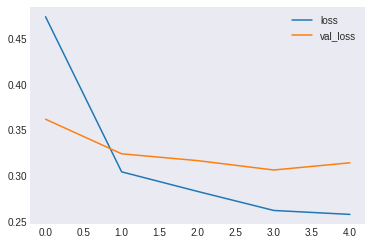

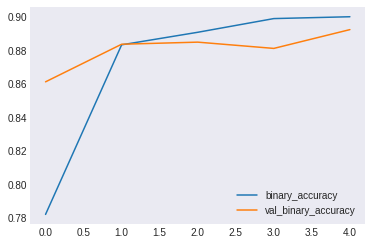

In [26]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_df.loc[:,['loss','val_loss']].plot()
hist_df.loc[:,['binary_accuracy','val_binary_accuracy']].plot()

In [27]:
model.save('face_detection.h5')

In [28]:
def get_class(img):
    img_arr = keras.preprocessing.image.img_to_array(img)
    img_arr = tf.expand_dims(img_arr, 0)
    pred = model.predict(img_arr)
    pred = (pred>0.5).astype(np.int)
    return class_name[pred[0][0]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


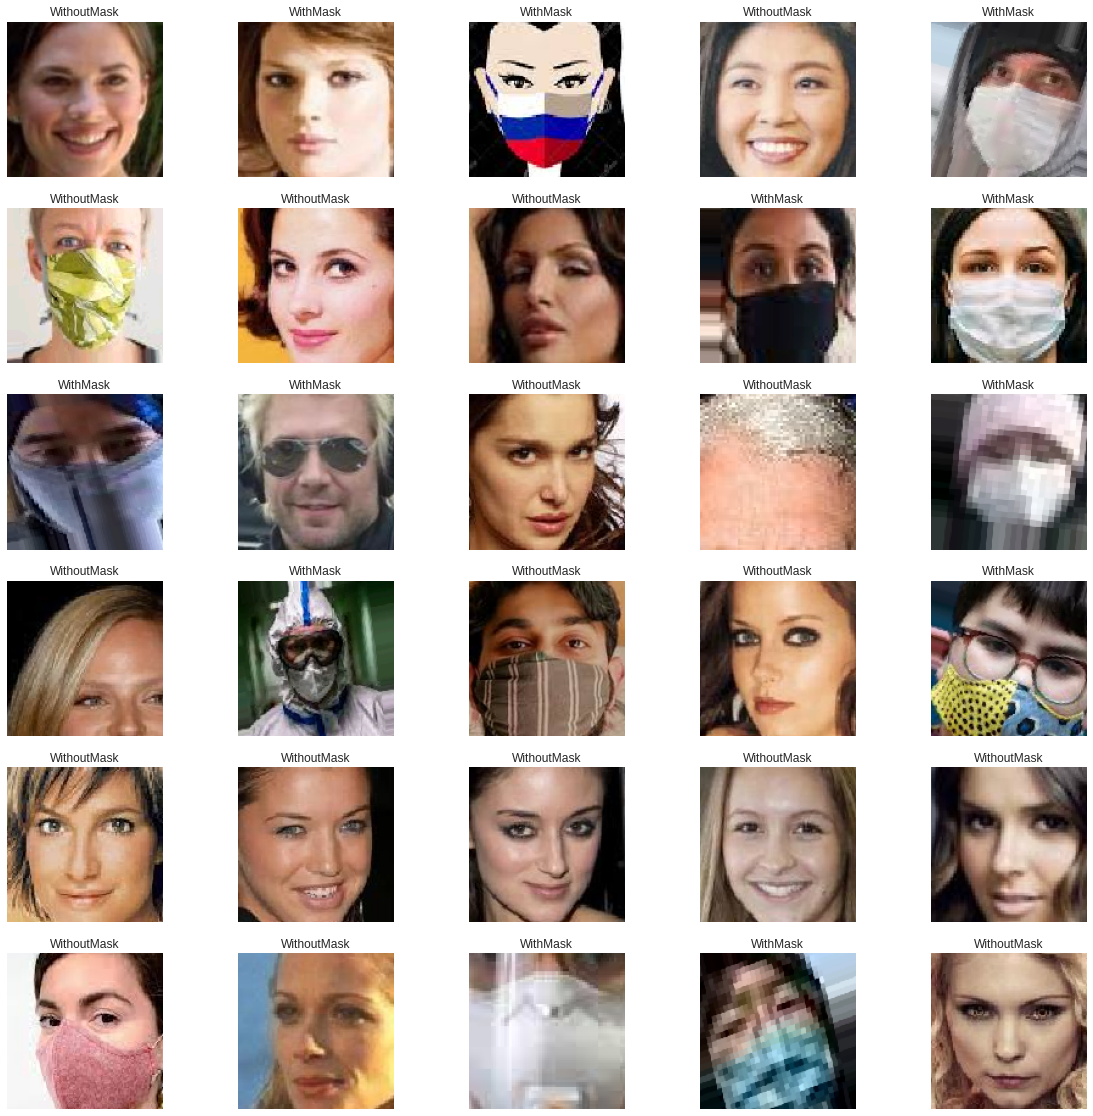

In [29]:
plt.figure(figsize=(20,20))
for img , _ in test_df.take(5):
    for i in range(30):
        ax = plt.subplot(6,5,i+1)
        plt.imshow(img[i])
        plt.title(get_class(img[i]))
        plt.axis('off')